In [68]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
from PIL import Image
import os
import torchvision.models as models
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import random
from collections import defaultdict
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision
import pandas as pd
import torch.nn.functional as F



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def preprocess_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
    transforms.Resize((227, 227)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4680, 0.4647, 0.3441], std=[0.2322, 0.2272, 0.2394]) 
    ]) 
    return transform(image).unsqueeze(0)

def get_indexes(arr, value):
    indexes = []
    for i in range(len(arr)):
        if arr[i] == value:
            indexes.append(i)
    return indexes

def get_length_per_class(dataloader, classes):
    class_counts = defaultdict(int)
    total = 0
    for batch in dataloader:
        _, labels = batch 
        labels = labels.numpy().tolist()
        for label in labels:
            class_counts[label] += 1
            total +=1

    class_counts = dict(sorted(class_counts.items()))
    for class_label, count in class_counts.items():
        print(f"Class {classes[class_label]}: {count} samples out of {total}")
def load_data(data_dir,
                           batch_size,
                           data_type,
                           noise_type,
                           noise_percentage,                           
                           transform,                           
                           data_percentage=1,
                           show_classes = False, random_seed=21):
    
    if noise_type == "None":
        noise_type = ""
        noise_percentage = ""
    else:
        noise_type = "/" + str(noise_type)
        noise_percentage = "/" + str(noise_percentage)
    path = data_dir + noise_type + "/" + data_type + noise_percentage
    print("path: ", path)
    dataset = ImageFolder(root=path, transform=transform)
    original_classes = dataset.classes 
    num_samples = len(dataset)
    indices = list(range(num_samples))

    labels = dataset.targets
    class_to_idx = dataset.class_to_idx
    needed_length = int(num_samples*data_percentage/100)
    expected_length_per_class = int(needed_length/len(original_classes))
    print(f"needed_length: {needed_length}, expected_length_per_class: {expected_length_per_class}")
    if data_percentage != 100:
        new_indices = []
        for key, value in class_to_idx.items():
            all_indixes_of_class = get_indexes(labels, value)
            new_indices.extend(all_indixes_of_class[:expected_length_per_class])
    else:
        new_indices = indices
    length_dataset = len(new_indices)
    print("length of final dataset:", length_dataset)

    
    # sampler = SubsetRandomSampler(new_indices)

    dataloader = DataLoader(dataset, sampler=new_indices, batch_size=batch_size)

    if show_classes:
        get_length_per_class(dataloader, original_classes)
        
    random.shuffle(new_indices)

   
    dataloader = DataLoader(dataset, sampler=new_indices, batch_size=batch_size)

    return dataloader, length_dataset, original_classes

def testing(model, classes, noise_percentage):

    results = pd.DataFrame(columns = ['Class', 'Accuracy', 'Recall', 'Precision', 'F_score'])

    model.eval()
    y_pred1 = torch.tensor([])
    y_target1 = torch.tensor([])
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(len(classes))]
        n_class_samples = [0 for _ in range(len(classes))]
        n_class_true_positives = [0 for _ in range(len(classes))]
        n_class_preds = [0 for _ in range(len(classes))]
        for images, labels in test_loader_dict[noise_percentage]:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
             
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            y_pred1 = torch.cat((predicted, y_pred1), dim=0)
            y_target1 = torch.cat((labels, y_target1), dim=0)
            
            for i in range(len(images)):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
                n_class_preds[pred] +=1                
                n_class_true_positives[pred] += int(pred == label)
                
                

        acc = round(100.0 * n_correct / n_samples, 2)
        print(f'Accuracy of the network: {acc} %')

        for i in range(len(classes)):
            precision = round(n_class_true_positives[i] / n_class_preds[i], 2)
            recall = round(n_class_true_positives[i] /n_class_samples[i], 2)
            f_score = round(2 * (precision * recall) / (precision + recall), 2) if (precision + recall) > 0 else 0
            

            results.loc[len(results.index)] = [classes[i], n_class_correct[i] *100 / n_class_samples[i], recall, precision, f_score] 
            
        results.loc[len(results.index)] = ['Total', acc, round(results['Recall'].mean(),2),
                                            round(results['Precision'].mean(), 2), round(results['F_score'].mean(), 2)]   
        return results











path_to_10 = "../data/vegetable_images/gaussian_noise/test/10/Bean/0002.jpg"
path_to_30 = "../data/vegetable_images/gaussian_noise/test/30/Bean/0002.jpg"
path_to_50 = "../data/vegetable_images/gaussian_noise/test/50/Bean/0002.jpg"
path_to_100 = "../data/vegetable_images/gaussian_noise/test/100/Bean/0002.jpg"

print('ready')





ready


In [69]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4680, 0.4647, 0.3441], std=[0.2322, 0.2272, 0.2394]) 
])   

noise_type = "gaussian_noise"
noise_percentage = 10
data_percentage = 100
total_size = 21000

train_size = data_percentage*total_size/100
data_dir = '../data/vegetable_images'

train_loader, train_size, classes = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "train",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)

valid_loader, valid_size, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "validation",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)

valid_loader_with_noise, _, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "validation",
                           noise_type = noise_type,
                           noise_percentage = noise_percentage,                           
                           transform = transform,                           
                           data_percentage=data_percentage)
dataloaders = {'train':  train_loader, 
               'val': valid_loader
               }
dataloaders_with_noise = {'train':  train_loader, 
               'val': valid_loader_with_noise
               }


test_loader,test_size_, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "test",
                           noise_type = "gaussian_noise",
                           noise_percentage = noise_percentage,                           
                           transform = transform,                           
                           data_percentage=data_percentage)


test_loader_without_noise, _, _ = load_data(data_dir =data_dir,
                           batch_size = 64,
                           data_type = "test",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)
dataset_sizes = {'train':  train_size, 
        'val': valid_size,
        'test': test_size_
       }


test_loader_dict = {0: test_loader_without_noise}

n = [10, 30, 50, 70, 100]


for i in n:
    test_loader,test_size_, _ = load_data(data_dir = data_dir,
                           batch_size = 64,
                           data_type = "test",
                           noise_type = "gaussian_noise",
                           noise_percentage = i,                           
                           transform = transform,                           
                           data_percentage=data_percentage)
    
    test_loader_dict[i] = test_loader
    

path:  ../data/vegetable_images/train
needed_length: 15000, expected_length_per_class: 1000
length of final dataset: 15000
path:  ../data/vegetable_images/validation
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  ../data/vegetable_images/gaussian_noise/validation/10
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  ../data/vegetable_images/gaussian_noise/test/10
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  ../data/vegetable_images/test
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  ../data/vegetable_images/gaussian_noise/test/10
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  ../data/vegetable_images/gaussian_noise/test/30
needed_length: 3000, expected_length_per_class: 200
length of final dataset: 3000
path:  ../data/vegetable_images/gaussian_noise/test/50
needed_length: 3000, exp

# TESTING ON THE IMAGES WITH 10% NOISE

In [53]:
alexnet = torch.load('../hypertuning/alexnet/alexnet_best.pth', map_location=torch.device('cpu'))


Accuracy of the network: 98.97 %


Class  Accuracy  Recall  Precision  F_score
0           Bean     99.00    0.99       0.99     0.99
1   Bitter_Gourd     99.00    0.99       1.00     0.99
2   Bottle_Gourd    100.00    1.00       0.99     0.99
3        Brinjal     97.50    0.97       0.99     0.98
4       Broccoli    100.00    1.00       1.00     1.00
5        Cabbage     99.50    0.99       0.99     0.99
6       Capsicum     93.50    0.94       1.00     0.97
7         Carrot    100.00    1.00       1.00     1.00
8    Cauliflower     99.50    0.99       0.99     0.99
9       Cucumber     99.50    0.99       0.98     0.98
10        Papaya     99.00    0.99       0.95     0.97
11        Potato    100.00    1.00       0.98     0.99
12       Pumpkin    100.00    1.00       0.98     0.99
13        Radish    100.00    1.00       1.00     1.00
14        Tomato     98.00    0.98       1.00     0.99
15         Total     98.97    0.99       0.99     0.99

In [55]:
results = testing(alexnet, classes, 10)
results

Accuracy of the network: 98.97 %


Class  Accuracy  Recall  Precision  F_score
0           Bean     99.00    0.99       0.99     0.99
1   Bitter_Gourd     99.00    0.99       1.00     0.99
2   Bottle_Gourd    100.00    1.00       0.99     0.99
3        Brinjal     97.50    0.97       0.99     0.98
4       Broccoli    100.00    1.00       1.00     1.00
5        Cabbage     99.50    0.99       0.99     0.99
6       Capsicum     93.50    0.94       1.00     0.97
7         Carrot    100.00    1.00       1.00     1.00
8    Cauliflower     99.50    0.99       0.99     0.99
9       Cucumber     99.50    0.99       0.98     0.98
10        Papaya     99.00    0.99       0.95     0.97
11        Potato    100.00    1.00       0.98     0.99
12       Pumpkin    100.00    1.00       0.98     0.99
13        Radish    100.00    1.00       1.00     1.00
14        Tomato     98.00    0.98       1.00     0.99
15         Total     98.97    0.99       0.99     0.99

In [56]:
results = testing(alexnet, classes, 30)
results

Accuracy of the network: 69.4 %


Class  Accuracy  Recall  Precision  F_score
0           Bean      41.5    0.41       0.97     0.58
1   Bitter_Gourd      99.0    0.99       0.47     0.64
2   Bottle_Gourd      80.0    0.80       0.86     0.83
3        Brinjal      34.0    0.34       0.99     0.51
4       Broccoli      97.5    0.97       0.74     0.84
5        Cabbage      22.0    0.22       0.98     0.36
6       Capsicum      11.5    0.12       1.00     0.21
7         Carrot      91.5    0.92       0.95     0.93
8    Cauliflower      82.5    0.82       0.98     0.89
9       Cucumber      97.5    0.97       0.47     0.63
10        Papaya      88.5    0.89       0.73     0.80
11        Potato      90.0    0.90       0.87     0.88
12       Pumpkin     100.0    1.00       0.43     0.60
13        Radish      60.0    0.60       1.00     0.75
14        Tomato      45.5    0.46       1.00     0.63
15         Total      69.4    0.69       0.83     0.67

In [46]:
results_h = pd.read_csv('../hypertuning/alexnet/alexnet_results.csv', sep = ",")

results_h.loc[:, ['model',	'num_epochs',	'learning_rate',	'momentum',	'step',	'gamma',	'accuracy']].sort_values(by = 'accuracy', ascending= False)



model  num_epochs  learning_rate  momentum  step  gamma  accuracy
1  alexnet          10          0.005       0.0     3    0.5  0.990000
4  alexnet          10          0.005       0.1     3    0.1  0.988667
0  alexnet          10          0.005       0.0     3    0.1  0.988333
2  alexnet          10          0.005       0.0     4    0.1  0.988000
3  alexnet          10          0.005       0.0     4    0.5  0.988000
5  alexnet          10          0.005       0.1     3    0.5  0.985667
7  alexnet          10          0.005       0.1     4    0.5  0.985667
6  alexnet          10          0.005       0.1     4    0.1  0.985333

In [ ]:
import ast

def convert_to_2d_list(history_str):
    return ast.literal_eval(history_str)


results_h['history'] = results_h['history'].apply(convert_to_2d_list)
alexnet_h = list(results_h.sort_values(by = 'accuracy', ascending= False).loc[1, 'history'])
alexnet_h

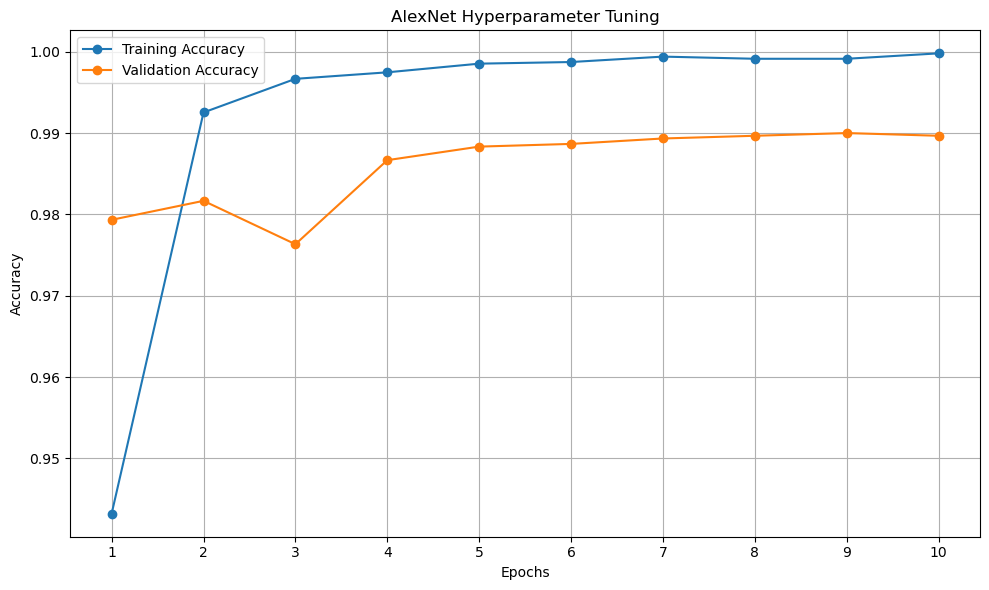

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(len(alexnet_h[0]))), alexnet_h[0], label='Training Accuracy', marker='o')
plt.plot(list(range(len(alexnet_h[1]))), alexnet_h[1], label='Validation Accuracy', marker='o')

plt.xticks(range(10), range(1, 11))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('AlexNet Hyperparameter Tuning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [59]:
resnet = torch.load('../hypertuning/resnet/best_resnet.pth', map_location=torch.device('cpu'))


In [60]:
results = testing(resnet, classes, 10)
results


Accuracy of the network: 98.3 %


Class  Accuracy  Recall  Precision  F_score
0           Bean     100.0    1.00       0.99     0.99
1   Bitter_Gourd      99.0    0.99       0.99     0.99
2   Bottle_Gourd      97.5    0.97       0.99     0.98
3        Brinjal      97.0    0.97       0.95     0.96
4       Broccoli      99.5    0.99       0.98     0.98
5        Cabbage      98.5    0.98       1.00     0.99
6       Capsicum      97.0    0.97       1.00     0.98
7         Carrot     100.0    1.00       1.00     1.00
8    Cauliflower      97.5    0.97       0.99     0.98
9       Cucumber      99.0    0.99       0.97     0.98
10        Papaya      89.5    0.90       0.99     0.94
11        Potato     100.0    1.00       0.99     0.99
12       Pumpkin     100.0    1.00       0.93     0.96
13        Radish     100.0    1.00       1.00     1.00
14        Tomato     100.0    1.00       1.00     1.00
15         Total      98.3    0.98       0.98     0.98

In [64]:
results_h = pd.read_csv('../hypertuning/resnet/resnet_results.csv', sep = ",")

results_h.loc[:, ['model',	'num_epochs',	'learning_rate',	'momentum',	'step',	'gamma',	'accuracy']].sort_values(by = 'accuracy', ascending= False)



model  num_epochs  learning_rate  momentum  step  gamma  accuracy
6  resnet          10          0.005       0.1     4    0.1  0.994667
4  resnet          10          0.005       0.1     3    0.1  0.994000
7  resnet          10          0.005       0.1     4    0.5  0.993667
1  resnet          10          0.005       0.0     3    0.5  0.993000
3  resnet          10          0.005       0.0     4    0.5  0.993000
5  resnet          10          0.005       0.1     3    0.5  0.993000
0  resnet          10          0.005       0.0     3    0.1  0.991667
2  resnet          10          0.005       0.0     4    0.1  0.991667

In [65]:
import ast

def convert_to_2d_list(history_str):
    return ast.literal_eval(history_str)


results_h['history'] = results_h['history'].apply(convert_to_2d_list)
resnet_h = list(results_h.sort_values(by = 'accuracy', ascending= False).loc[1, 'history'])
resnet_h

[[0.7904,
  0.9772666666666667,
  0.9905333333333334,
  0.9957333333333334,
  0.9976,
  0.9983333333333334,
  0.9985333333333334,
  0.9986666666666667,
  0.9987333333333334,
  0.9988],
 [0.9583333333333333,
  0.9803333333333333,
  0.9863333333333333,
  0.9913333333333333,
  0.992,
  0.9926666666666666,
  0.993,
  0.993,
  0.993,
  0.993]]

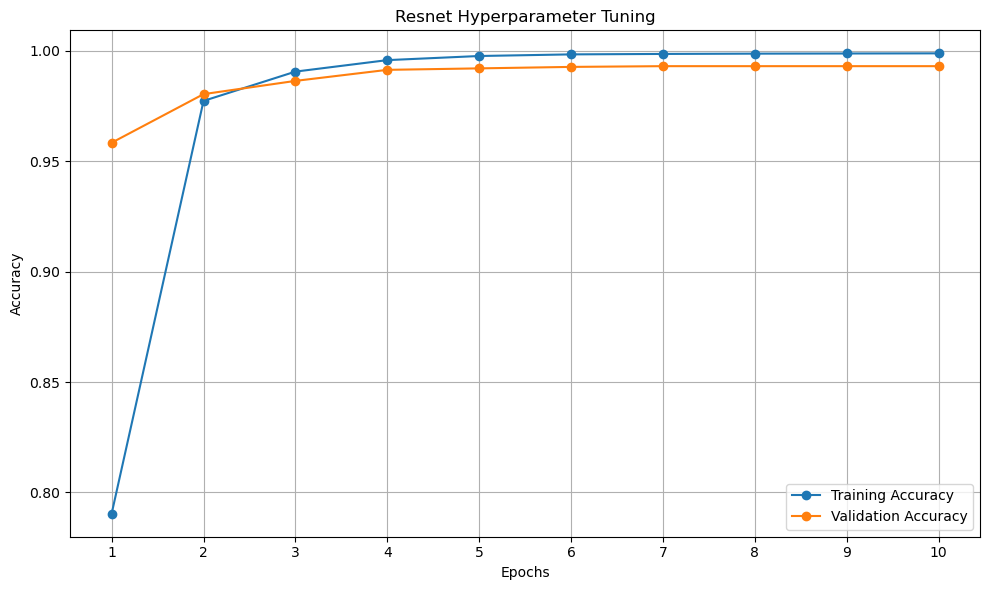

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(len(resnet_h[0]))), resnet_h[0], label='Training Accuracy', marker='o')
plt.plot(list(range(len(resnet_h[1]))), resnet_h[1], label='Validation Accuracy', marker='o')

plt.xticks(range(10), range(1, 11))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Resnet Hyperparameter Tuning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [72]:
efficientnet = torch.load('../hypertuning/efficientnet/best_efficientnet.pth', map_location=torch.device('cpu'))


In [73]:
results = testing(efficientnet, classes, 10)
results


Accuracy of the network: 98.13 %


Class  Accuracy  Recall  Precision  F_score
0           Bean     99.50    0.99       0.99     0.99
1   Bitter_Gourd     99.00    0.99       0.96     0.97
2   Bottle_Gourd     91.00    0.91       0.99     0.95
3        Brinjal     98.50    0.98       0.95     0.96
4       Broccoli     98.00    0.98       0.99     0.98
5        Cabbage     99.00    0.99       0.99     0.99
6       Capsicum     97.50    0.97       0.99     0.98
7         Carrot     99.50    0.99       1.00     0.99
8    Cauliflower     97.00    0.97       0.99     0.98
9       Cucumber     99.00    0.99       0.93     0.96
10        Papaya     95.50    0.95       0.98     0.96
11        Potato     99.50    0.99       0.99     0.99
12       Pumpkin     99.50    0.99       0.98     0.98
13        Radish     99.50    0.99       1.00     0.99
14        Tomato    100.00    1.00       1.00     1.00
15         Total     98.13    0.98       0.98     0.98

In [74]:
results_h = pd.read_csv('../hypertuning/efficientnet/efficientnet_results.csv', sep = ",")

results_h.loc[:, ['model',	'num_epochs',	'learning_rate',	'momentum',	'step',	'gamma',	'accuracy']].sort_values(by = 'accuracy', ascending= False)



model  num_epochs  learning_rate  momentum  step  gamma  accuracy
4  efficientnet          10          0.005       0.1     3    0.1  0.988000
0  efficientnet          10          0.005       0.0     3    0.1  0.987333
6  efficientnet          10          0.005       0.1     4    0.1  0.987333
7  efficientnet          10          0.005       0.1     4    0.5  0.986333
3  efficientnet          10          0.005       0.0     4    0.5  0.985667
1  efficientnet          10          0.005       0.0     3    0.5  0.985333
2  efficientnet          10          0.005       0.0     4    0.1  0.984667
5  efficientnet          10          0.005       0.1     3    0.5  0.983667

In [75]:
import ast

def convert_to_2d_list(history_str):
    return ast.literal_eval(history_str)


results_h['history'] = results_h['history'].apply(convert_to_2d_list)
efficientnet_h = list(results_h.sort_values(by = 'accuracy', ascending= False).loc[1, 'history'])
efficientnet_h

[[0.6863333333333334,
  0.9455333333333333,
  0.9698,
  0.9815333333333334,
  0.9878666666666667,
  0.9904666666666667,
  0.9906,
  0.9912666666666667,
  0.9917333333333334,
  0.9908666666666667],
 [0.9193333333333333,
  0.954,
  0.9713333333333333,
  0.98,
  0.9836666666666667,
  0.984,
  0.9843333333333333,
  0.9846666666666666,
  0.985,
  0.9853333333333333]]

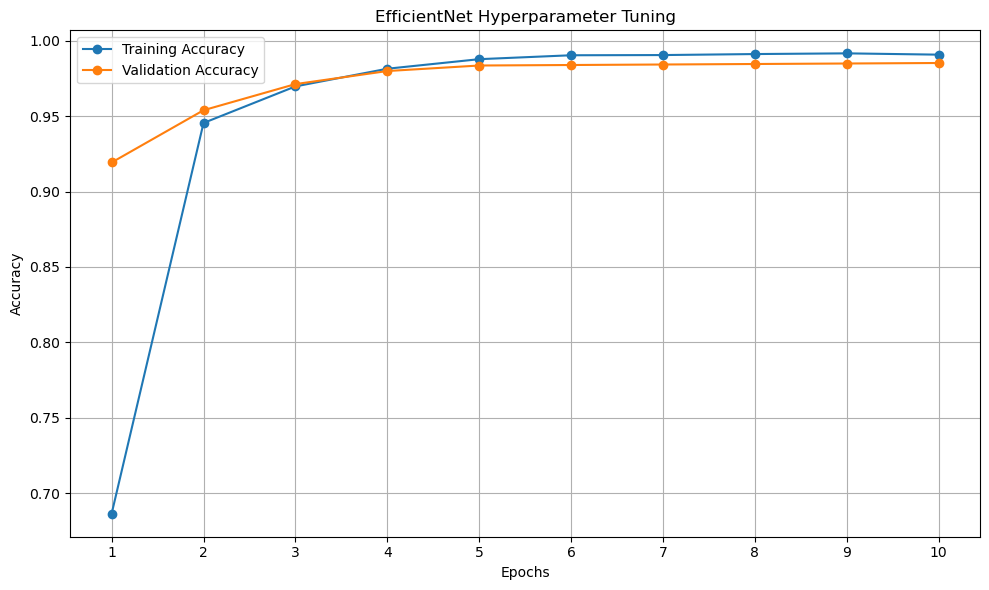

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(len(efficientnet_h[0]))), efficientnet_h[0], label='Training Accuracy', marker='o')
plt.plot(list(range(len(efficientnet_h[1]))), efficientnet_h[1], label='Validation Accuracy', marker='o')

plt.xticks(range(10), range(1, 11))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('EfficientNet Hyperparameter Tuning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





torch.Size([1, 64, 56, 56])


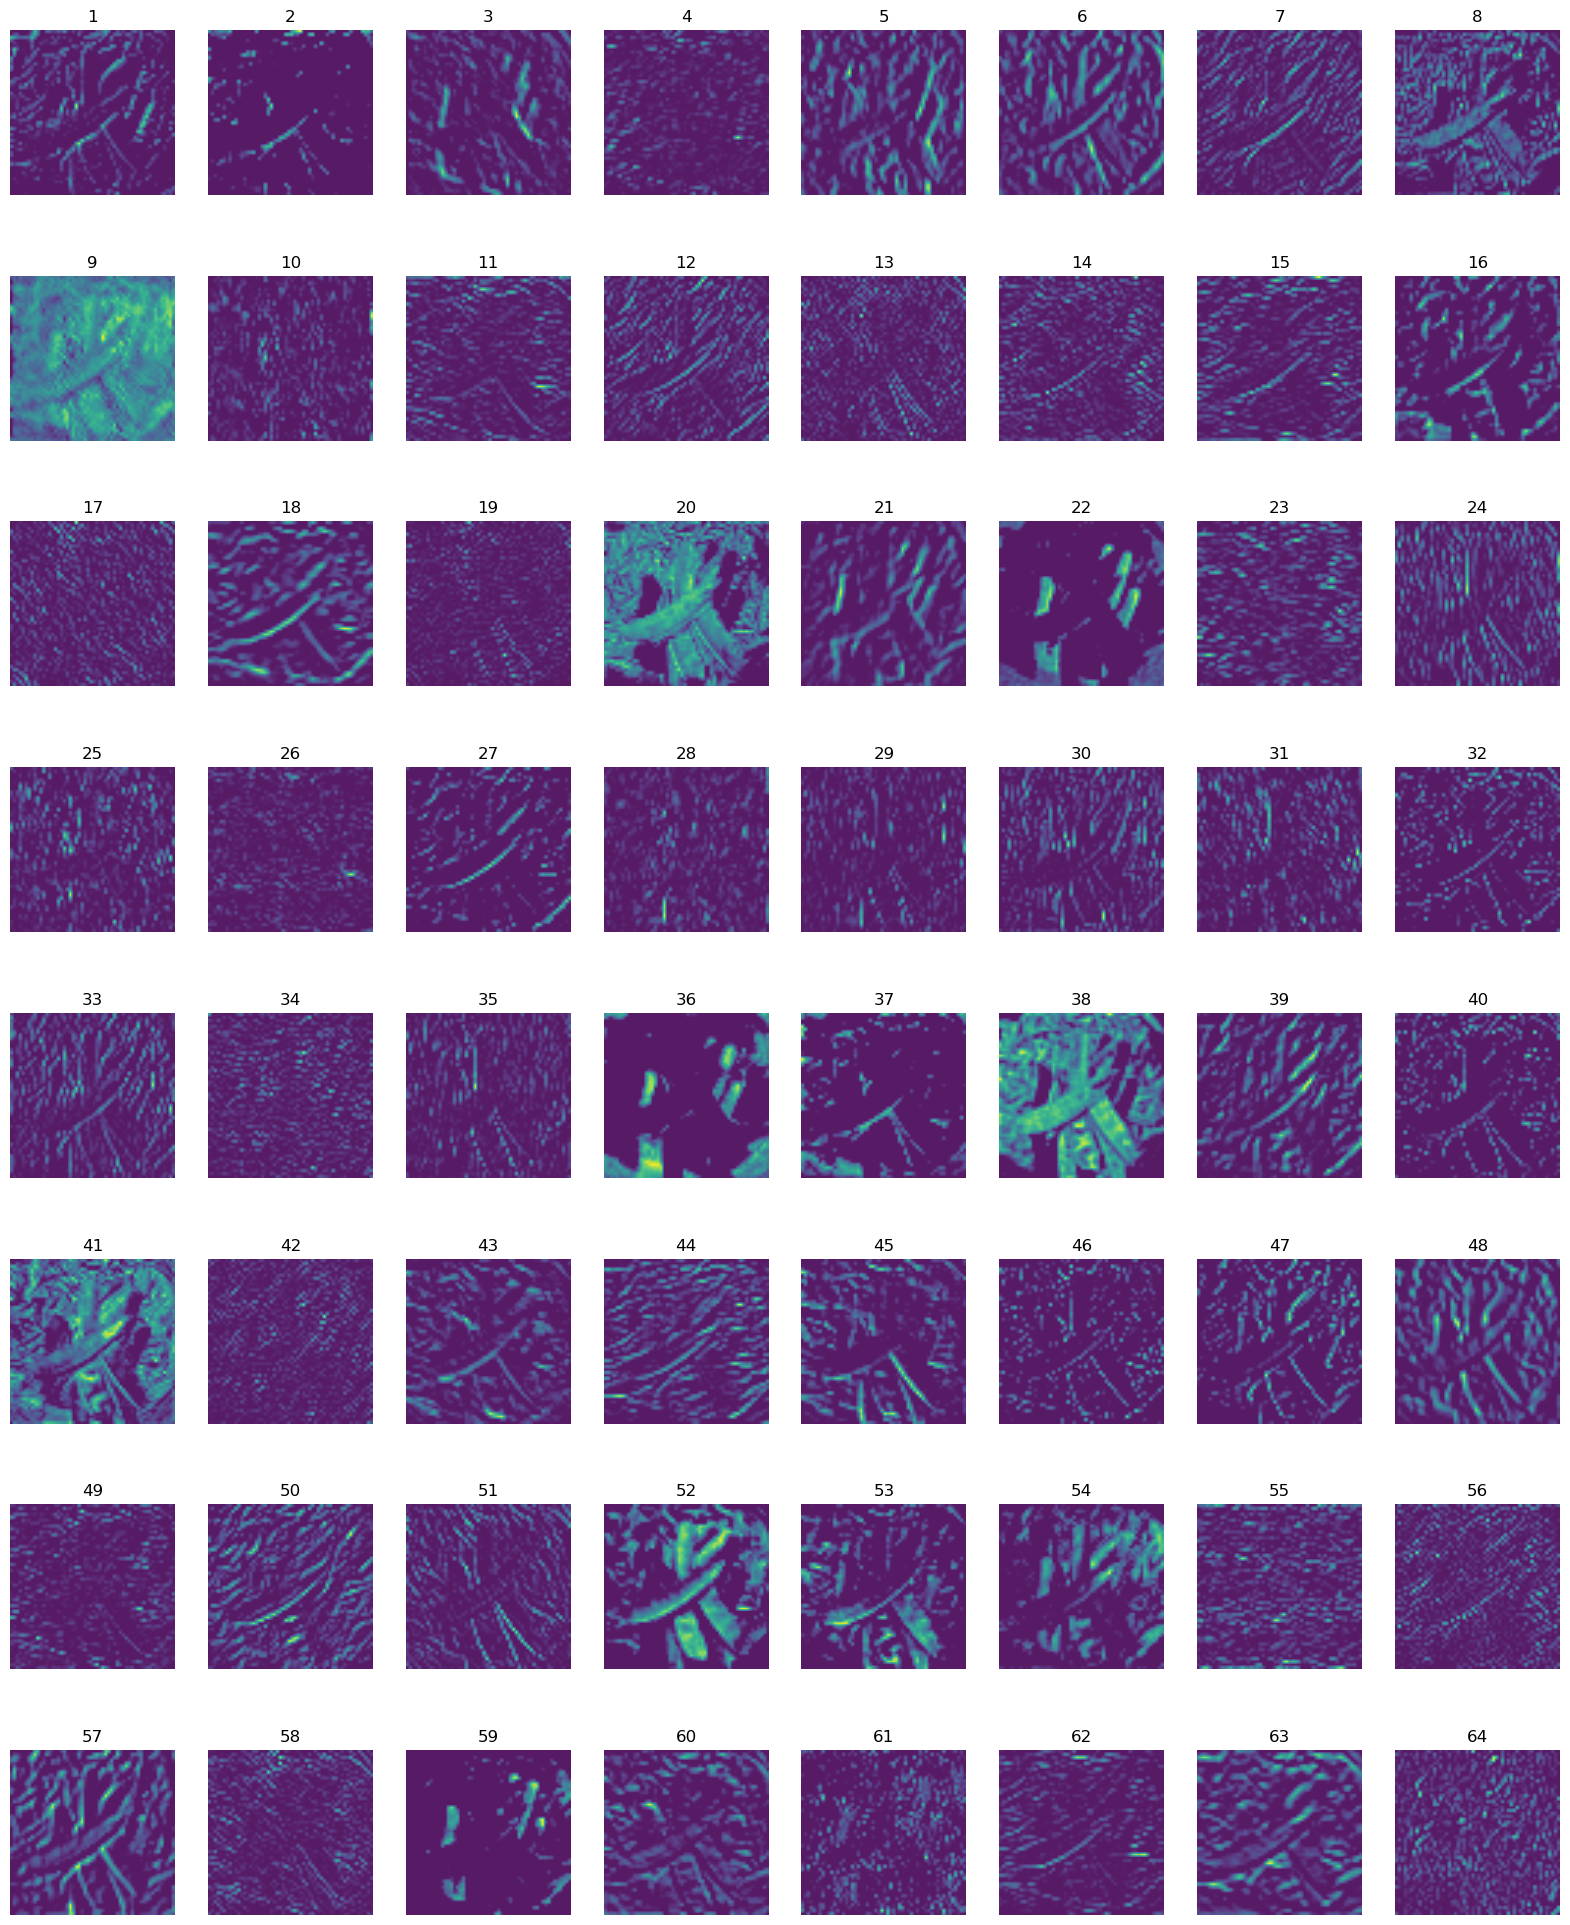

In [ ]:
def show_features(model, image_path, num_rows, num_cols):
    input_image = preprocess_image(image_path)
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    cnn = 'cnn_0'
    model_children = list(model.children())
    model_children[0][0].register_forward_hook(get_activation(cnn))


    with torch.no_grad():
        output = model(input_image)
    print(np.shape(activation[cnn]))

    

    plt.figure(figsize=(20, 25))

    dimensi_iter = activation[cnn][0,:,:,:].size(dim=0)
    for i in range(dimensi_iter):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(activation[cnn][0,i,:,:].cpu().numpy(), cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear')
        plt.axis('off')
        plt.title(i + 1)


    plt.show()

    
show_features(alexnet, path_to_10, 8, 8)

In [ ]:
resnet = torch.load('../models/resnet_without_noise.pth', map_location=torch.device('cpu'))
testing(resnet)

Accuracy of the network: 99.2 %
Accuracy of Bean: 100.0 %
Accuracy of Bitter_Gourd: 99.0 %
Accuracy of Bottle_Gourd: 100.0 %
Accuracy of Brinjal: 99.5 %
Accuracy of Broccoli: 98.5 %
Accuracy of Cabbage: 99.5 %
Accuracy of Capsicum: 99.5 %
Accuracy of Carrot: 98.5 %
Accuracy of Cauliflower: 98.0 %
Accuracy of Cucumber: 98.0 %


In [ ]:
efficientnet = torch.load('../models/efficientnet_without_noise.pth', map_location=torch.device('cpu'))
testing(efficientnet)

Accuracy of the network: 96.53333333333333 %
Accuracy of Bean: 99.5 %
Accuracy of Bitter_Gourd: 99.0 %
Accuracy of Bottle_Gourd: 87.0 %
Accuracy of Brinjal: 98.0 %
Accuracy of Broccoli: 97.0 %
Accuracy of Cabbage: 98.0 %
Accuracy of Capsicum: 97.0 %
Accuracy of Carrot: 97.5 %
Accuracy of Cauliflower: 95.5 %
Accuracy of Cucumber: 96.0 %


In [92]:
vgg16 = torch.load('../models/vgg16_without_noise.pth', map_location=torch.device('cpu'))
testing(vgg16, classes)

Accuracy of the network: 96.3 %
Accuracy of Bean: 100.0 %
Accuracy of Bitter_Gourd: 99.0 %
Accuracy of Bottle_Gourd: 87.0 %
Accuracy of Brinjal: 93.5 %
Accuracy of Broccoli: 99.5 %
Accuracy of Cabbage: 99.0 %
Accuracy of Capsicum: 79.5 %
Accuracy of Carrot: 98.5 %
Accuracy of Cauliflower: 95.0 %
Accuracy of Cucumber: 99.0 %
Accuracy of Papaya: 98.0 %
Accuracy of Potato: 100.0 %
Accuracy of Pumpkin: 99.5 %
Accuracy of Radish: 99.5 %
Accuracy of Tomato: 97.5 %


In [105]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

torch.Size([1, 64, 56, 56])


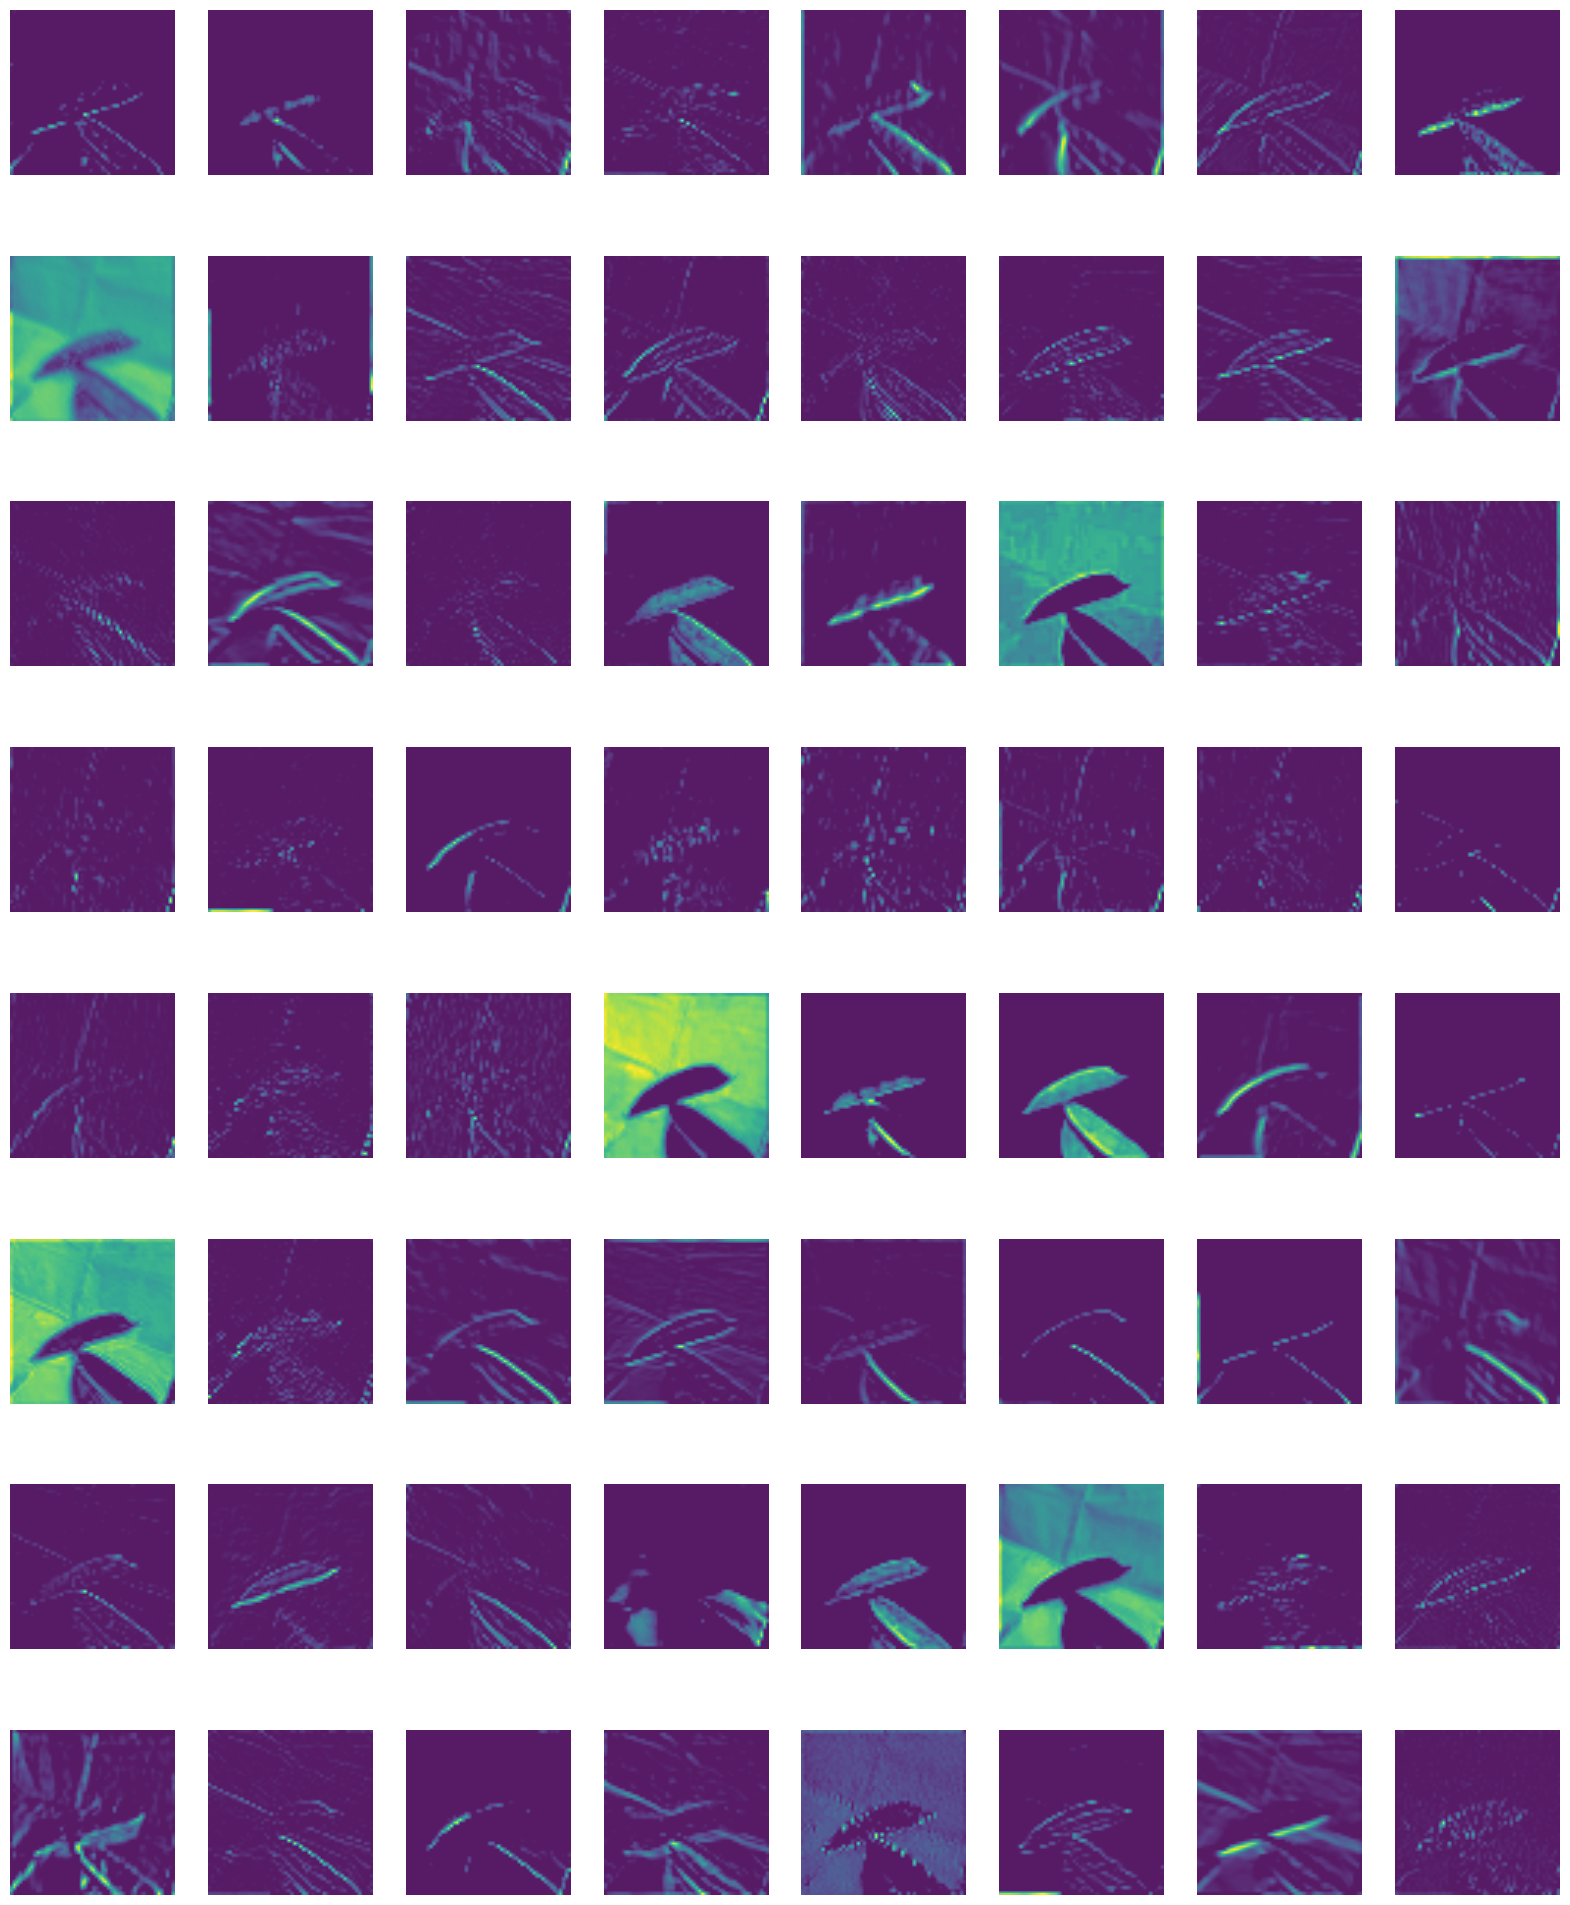

In [106]:

image_path = "../data/test/0028.jpg"  
input_image = preprocess_image(image_path)



cnn = 'cnn_0'
alexnet_children = list(alexnet.children())
alexnet_children[0][0].register_forward_hook(get_activation(cnn))


with torch.no_grad():
    output = alexnet(input_image)
print(np.shape(activation[cnn]))

num_rows = 8
num_cols = 8

plt.figure(figsize=(20, 25))

dimensi_iter = activation[cnn][0,:,:,:].size(dim=0)
for i in range(dimensi_iter):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(activation[cnn][0,i,:,:].cpu().numpy(), cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear')
    plt.axis('off')


plt.show()





In [113]:
def show_features(model, image_path, num_rows, num_cols):
    input_image = preprocess_image(image_path)
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    cnn = 'cnn_0'
    model_children = list(model.children())
    model_children[0][0].register_forward_hook(get_activation(cnn))


    with torch.no_grad():
        output = model(input_image)
    print(np.shape(activation[cnn]))

    

    plt.figure(figsize=(20, 25))

    dimensi_iter = activation[cnn][0,:,:,:].size(dim=0)
    for i in range(dimensi_iter):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(activation[cnn][0,i,:,:].cpu().numpy(), cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear')
        plt.axis('off')
        plt.title(i + 1)


    plt.show()

    


torch.Size([1, 64, 56, 56])


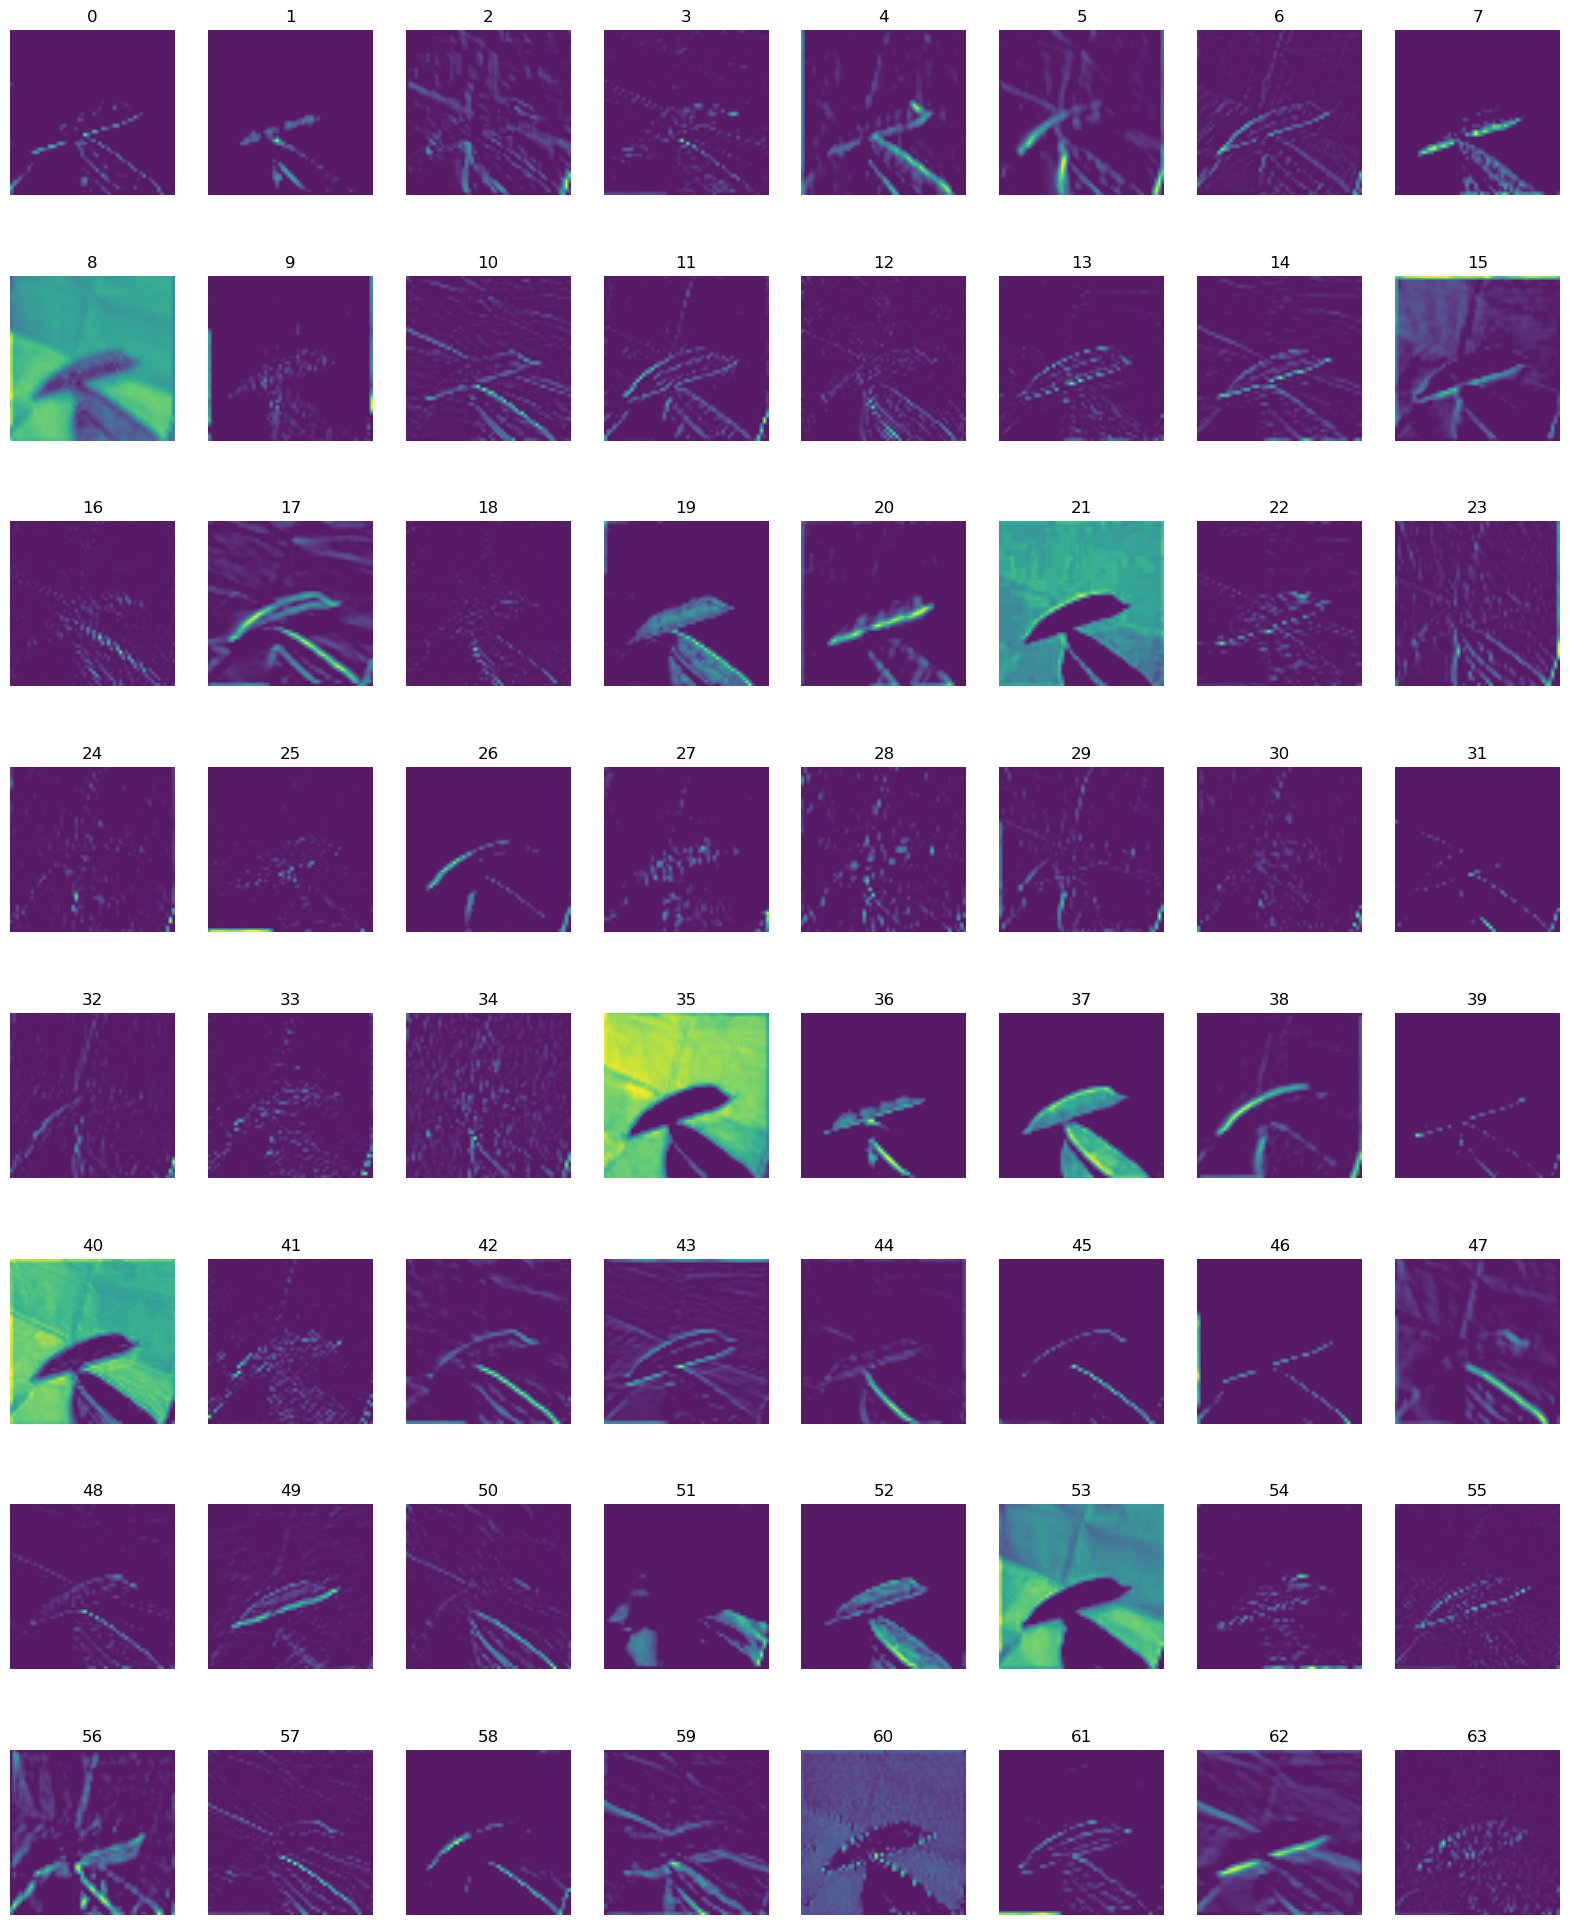

In [114]:
show_features(alexnet, "../data/test/0028.jpg", 8, 8)

torch.Size([1, 64, 227, 227])


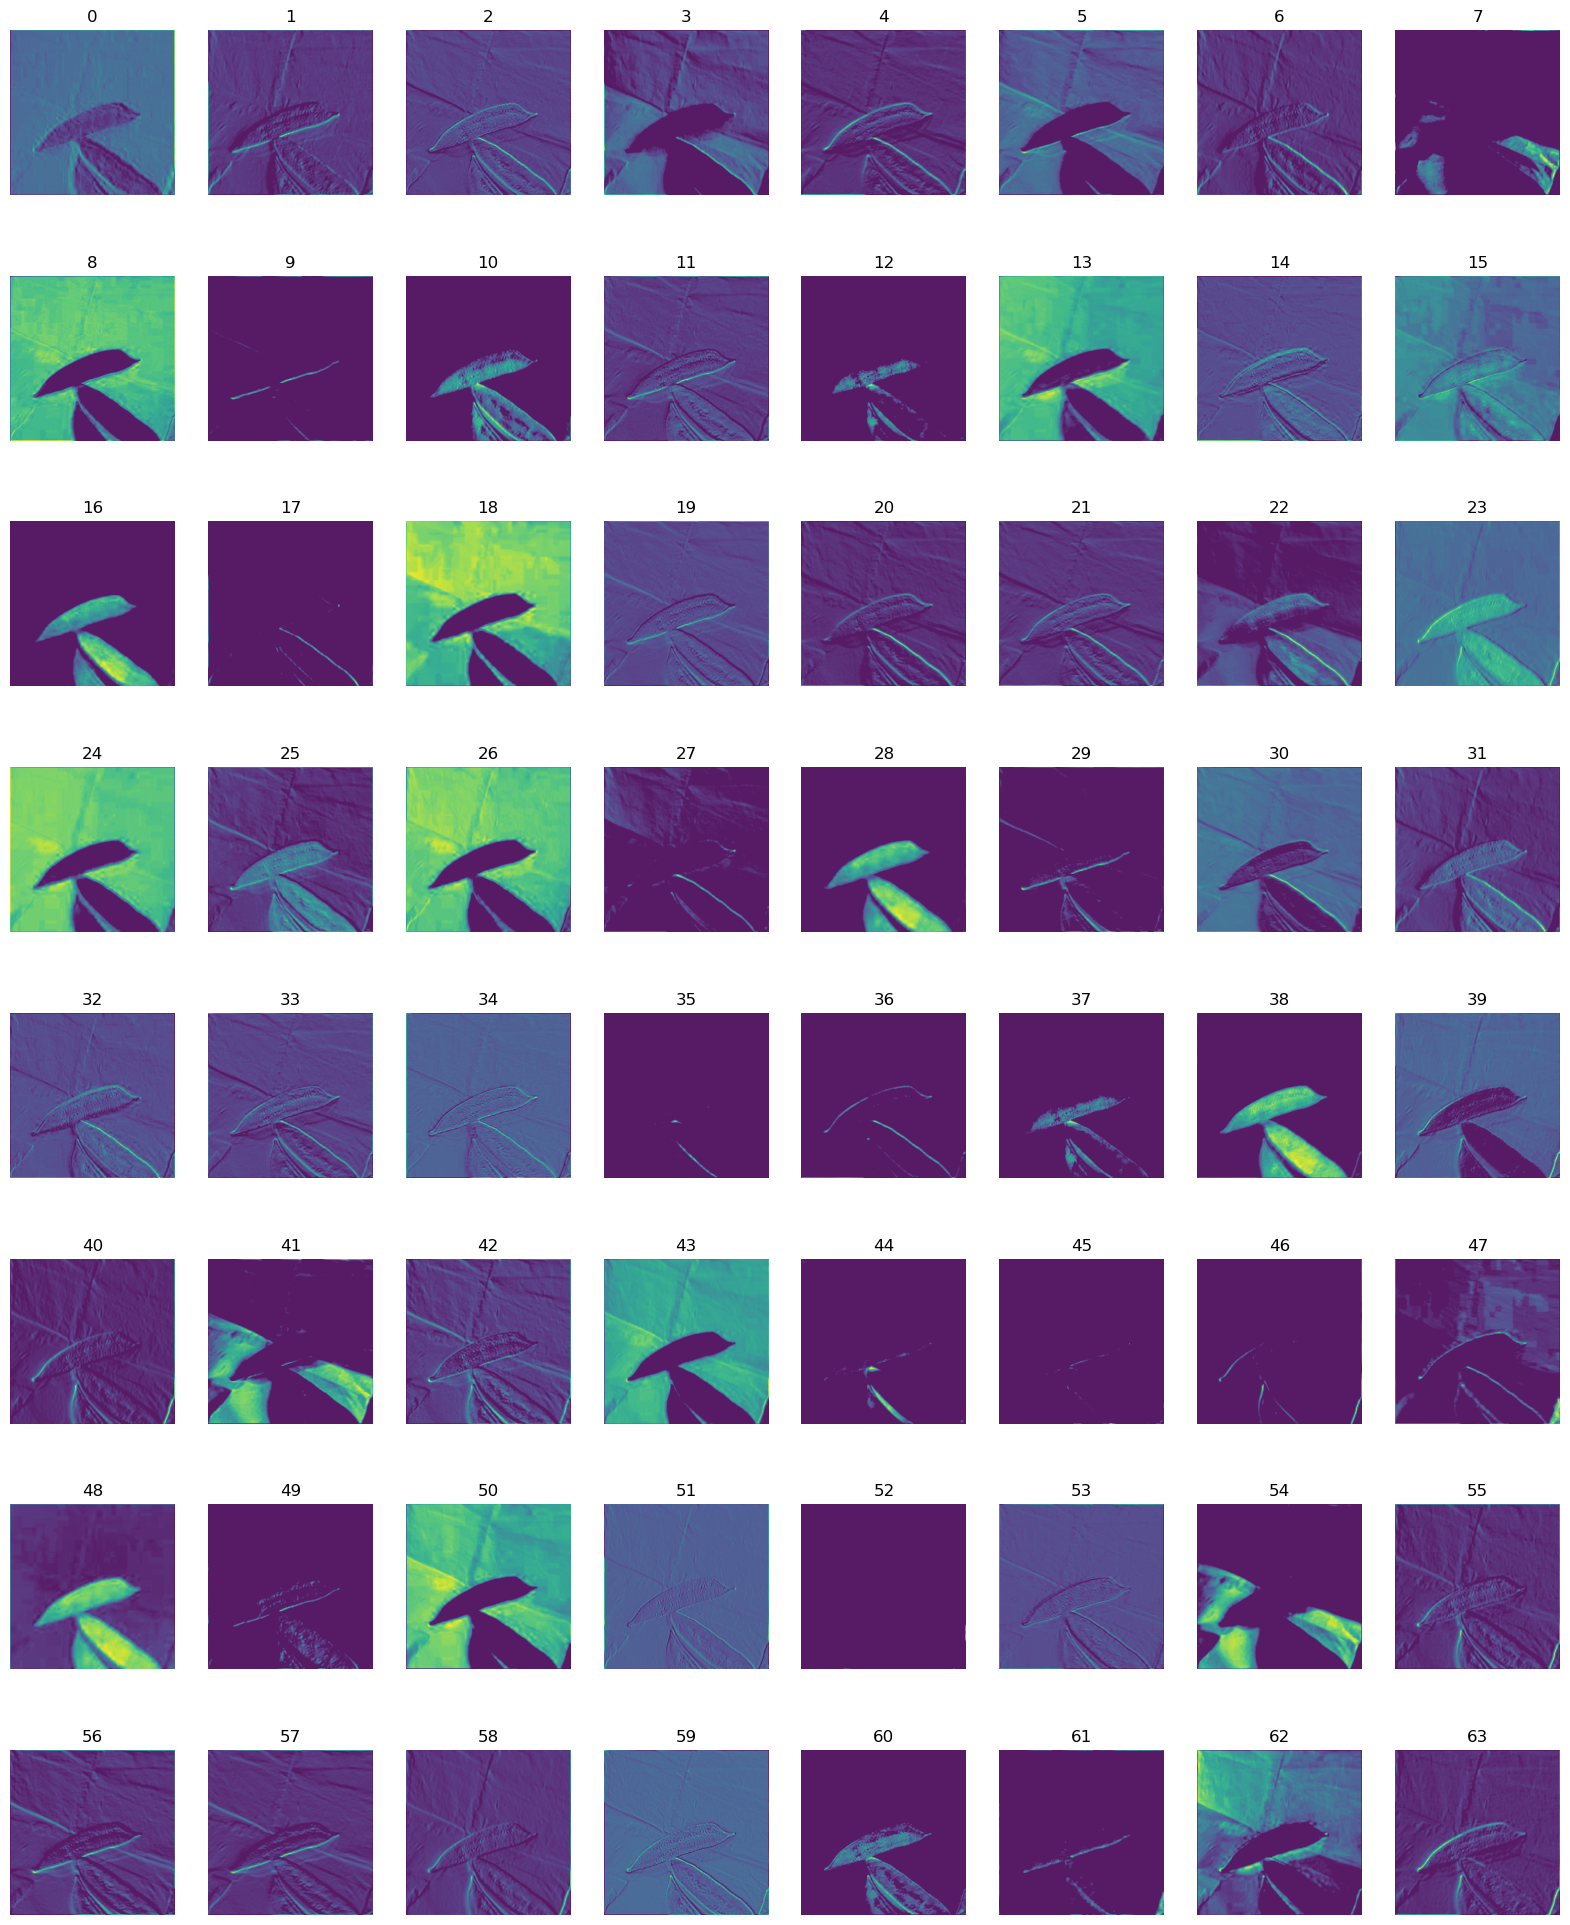

In [115]:
show_features(vgg16, "../data/test/0028.jpg", 8, 8)